# **DISEASE DETECTION AND IDENTIFICATION BASED ON SYMPTOMS**

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kakan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kakan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# importing necessary libraries
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split,cross_val_score
import math
import operator
import pickle
import re
from nltk.stem import WordNetLemmatizer
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from statistics import mean
from nltk.corpus import wordnet 
import requests
from bs4 import BeautifulSoup
from itertools import combinations
from time import time
from collections import Counter
import operator
import warnings
import matplotlib.pyplot as plt
# To ignore unnecessary warnings
warnings.simplefilter("ignore")


Obtained DISEASE SYMPTOM dataset from kaggle and calculating TF-IDF values

In [3]:
df = pd.read_csv("Dataset\dis_sym_dataset_norm.csv")

# extract disease labels and store them in 'documentname_list'
documentname_list= list(df['label_dis'])
df=df.iloc[:,1:]
columns_name=list(df.columns)
documentname_list=list(documentname_list)

#extract symptoms and store them in 'columns_name'
N=len(df)
M=len(columns_name)

# symptoms IDF
idf={}
for col in columns_name:
  temp=np.count_nonzero(df[col])
  idf[col]=np.log(N/temp)

# disease,symptom TF
tf={}
for i in range(N):
  for col in columns_name:
    key=(documentname_list[i],col)
    tf[key]=df.loc[i,col]

# disease,symptom TF.IDF
tf_idf={}
for i in range(N):
  for col in columns_name:
    key=(documentname_list[i],col)
    tf_idf[key]=float(idf[col])*float(tf[key])

In [4]:
# The matrix D will contain the TF-IDF values for each disease-symptom pair.
# rows - diseases
# columns - symptoms
D = np.zeros((N, M),dtype='float32')
for i in tf_idf:
    sym = columns_name.index(i[1])
    dis=documentname_list.index(i[0])
    D[dis][sym] = tf_idf[i]

similarity calculation using cosine siilarity and TF-IDF values

In [5]:

# cosine dot product
def cosine_dot(a, b):
    if np.linalg.norm(a) == 0 or np.linalg.norm(b) == 0:
        return 0
    else:
        temp = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        return temp

# data to lower case
def convert_tolowercase(data):
    return data.lower()

# tokenization
def regextokenizer_func(data):
    tokenizer = RegexpTokenizer(r'\w+')
    data = tokenizer.tokenize(data)
    return data

# function to generate query vector for tf_idf
def gen_vector(tokens):
    Q = np.zeros(M)
    counter = Counter(tokens)
    query_weights = {}
    for token in np.unique(tokens):
        tf = counter[token]
        try:
          idf_temp=idf[token]
        except:
          pass
        try:
            ind = columns_name.index(token)
            Q[ind] = tf*idf_temp
        except:
            pass
    return Q

# function to calculate tf_idf_score
def tf_idf_score(k, query):
    query_weights = {}
    for key in tf_idf:
        if key[1] in query:
            try:
                query_weights[key[0]] += tf_idf[key]
            except:
                query_weights[key[0]] = tf_idf[key]
    query_weights = sorted(query_weights.items(), key=lambda x: x[1], reverse=True)
  
    l = []
    for i in query_weights[:k]:
        l.append(i)
    return l

# function to calculte Cosine Similarity 
def cosine_similarity(k, query):
    d_cosines = []
    query_vector = gen_vector(query)
    for d in D:
        d_cosines.append(cosine_dot(query_vector, d))
    out = np.array(d_cosines).argsort()[-k:][::-1]
    
    final_display_disease={}
    for lt in set(out):
      final_display_disease[lt] = float(d_cosines[lt])
    return final_display_disease

Retrieving symptoms list for a given input from thesaurus.com and Wordnet 

In [6]:
#  list of synonyms of word from thesaurus.com (https://www.thesaurus.com/) and wordnet (https://www.nltk.org/howto/wordnet.html)

def synonyms(term):
    synonyms = []
    response = requests.get('https://www.thesaurus.com/browse/{}'.format(term))
    soup = BeautifulSoup(response.content,  "html.parser")
    try:
        container=soup.find('section', {'class': 'MainContentContainer'}) 
        row=container.find('div',{'class':'css-191l5o0-ClassicContentCard'})
        row = row.find_all('li')
        for x in row:
            synonyms.append(x.get_text())
    except:
        None
    for syn in wordnet.synsets(term):
        synonyms+=syn.lemma_names()
    return set(synonyms)

In [7]:
# instantiating objects of libraries
splitter = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

*dis_sym_dataset_comb -> dataset generated by combining symptoms for each disease.*

*dis_sym_dataset_norm -> dataset which contains a single row for each diseases with the symptoms for that corresponding disease.*

*dis_symp_dict -> contains list of symptoms*

In [8]:
# Load Dataset scraped from NHP (https://www.nhp.gov.in/disease-a-z) & Wikipedia
# Web Scrapping and Dataset creation is done in a separate program
df_comb = pd.read_csv("Dataset\dis_sym_dataset_comb.csv") 
df_norm = pd.read_csv("Dataset\dis_sym_dataset_norm.csv") 
Y = df_norm.iloc[:, 0:1]
X = df_norm.iloc[:, 1:]
# List of symptoms
dataset_symptoms = list(X.columns)
diseases = list(set(Y['label_dis']))
diseases.sort()

Taking input from user (symptoms)

In [9]:
# Taking symptoms from user as input
# Preprocessing symtoms 
user_symptoms = str(input("\nPlease enter symptoms you experience separated by comma(,):\n")).lower().split(',')
# user_symptoms = st.text_input("Enter symptoms separated by comma (,):").lower().split(',')
processed_user_symptoms=[]
for sym in user_symptoms:
    sym=sym.strip()
    sym=sym.replace('-',' ')
    sym=sym.replace("'",'')
    sym = ' '.join([lemmatizer.lemmatize(word) for word in splitter.tokenize(sym)])
    processed_user_symptoms.append(sym) 

Performing Query Expansion

In [10]:
# Finding all of the synonyms for each user symptom and adding them to the pre-processed symptom string
user_symptoms = []
for user_sym in processed_user_symptoms:
    user_sym = user_sym.split()
    str_sym = set()
    for comb in range(1, len(user_sym)+1):
        for subset in combinations(user_sym, comb):
            subset=' '.join(subset)
            subset = synonyms(subset) 
            str_sym.update(subset)
    str_sym.add(' '.join(user_sym))
    user_symptoms.append(' '.join(str_sym).replace('_',' '))
# query expansion is carried out by combining synonyms discovered for every symptom that was initially input.

print("After query expansion done by using the symptoms entered")
print(user_symptoms)


After query expansion done by using the symptoms entered
['feverishness febricity pyrexia fever febrility', 'insensate frigid cold cold-blooded dusty low temperature moth-eaten frigidity common cold stale frigidness coldness inhuman', 'coughing cough']


In [11]:
# Iterate through every symptom in the dataset and compare its similarity score to the user-inputted synonym string.
# If similarity>0.5 -> add the symptom to the final list

found_symptoms = set()
for idx, data_sym in enumerate(dataset_symptoms):
    data_sym_split=data_sym.split()
    for user_sym in user_symptoms:
        count=0
        for symp in data_sym_split:
            if symp in user_sym.split():
                count+=1
        if count/len(data_sym_split)>0.5:
            found_symptoms.add(data_sym)
found_symptoms = list(found_symptoms)

In [12]:
# Print all found symptoms
print("Top matching symptoms from your search!")
for idx, symp in enumerate(found_symptoms):
    print(idx,":",symp)

# Ask the user to choose from a list of relevant symptoms that were detected in the dataset.
select_list = input("\n Select the relevant symptoms. Enter indices (separated-space):\n").split()

dis_list = set()
final_symp = [] 
counter_list = []
for idx in select_list:
    symp=found_symptoms[int(idx)]
    final_symp.append(symp)
    dis_list.update(set(df_norm[df_norm[symp]==1]['label_dis']))
   
for dis in dis_list:
    row = df_norm.loc[df_norm['label_dis'] == dis].values.tolist()
    row[0].pop(0)
    for idx,val in enumerate(row[0]):
        if val!=0 and dataset_symptoms[idx] not in final_symp:
            counter_list.append(dataset_symptoms[idx])

# Symptoms that co-occur with the ones selected by user              
dict_symp = dict(Counter(counter_list))
dict_symp_tup = sorted(dict_symp.items(), key=operator.itemgetter(1),reverse=True) 

#dict_symp_tup contains a list of tuples, where each tuple represents a co-occurring symptom along with its count, sorted by count in descending order.

Top matching symptoms from your search!
0 : coughing
1 : fever


In [13]:
# Iteratively recommend the user's top co-occurring symptoms and request that they choose the ones that apply. 

found_symptoms=[]
count=0
for tup in dict_symp_tup:
    count+=1
    found_symptoms.append(tup[0])
    if count%5==0 or count==len(dict_symp_tup):
        print("\nGeneral co-occuring symptoms:")
        for idx,ele in enumerate(found_symptoms):
            print(idx,":",ele)
        select_list = input("Do you have any of these symptoms? If Yes, enter the indices (space-separated), 'no' to stop, '-1' to skip:\n").lower().split()
        if select_list[0]=='no':
            break
        if select_list[0]=='-1':
            found_symptoms = [] 
            continue
        for idx in select_list:
            final_symp.append(found_symptoms[int(idx)])
        found_symptoms = [] 


General co-occuring symptoms:
0 : headache
1 : testicular pain
2 : vomiting
3 : barky cough
4 : sore throat

General co-occuring symptoms:
0 : maculopapular rash
1 : diarrhea
2 : confusion
3 : shortness breath
4 : feeling tired


Finalised Symptoms

In [14]:
# Find TF-IDF and Cosine Similarity using matched symptoms
k = 5

print("Finalised  list of Symptoms based on the inputs from the user : ")
for val in final_symp:
    print(val)


Finalised  list of Symptoms based on the inputs from the user : 
coughing
fever
headache
vomiting


Predicting the top 10 diseases based on symptoms given by user

In [15]:
k = 10
topk1=tf_idf_score(k,final_symp)
topk2=cosine_similarity(k,final_symp)

print(f"\nTop {k} diseases predicted based on TF_IDF Matching :\n")
i = 0
topk1_index_mapping = {}
for key, score in topk1:
  print(f"{i}. Disease : {key} \t Score : {round(score, 2)}")
  topk1_index_mapping[i] = key
  i += 1



Top 10 diseases predicted based on TF_IDF Matching :

0. Disease : Influenza 	 Score : 7.71
1. Disease : Acute encephalitis syndrome 	 Score : 5.92
2. Disease : Bubonic plague 	 Score : 5.92
3. Disease : Crimean Congo haemorrhagic fever (CCHF) 	 Score : 5.92
4. Disease : Japanese Encephalitis 	 Score : 5.92
5. Disease : Malaria 	 Score : 5.92
6. Disease : Brain Tumour 	 Score : 4.63
7. Disease : Carbon monoxide poisoning 	 Score : 4.63
8. Disease : Asthma 	 Score : 4.47
9. Disease : Brucellosis 	 Score : 4.47


In [16]:
# display top k diseases predicted with cosine probablity
print(f"Top {k} disease based on Cosine Similarity Matching :\n ")
topk2_sorted = dict(sorted(topk2.items(), key=lambda kv: kv[1], reverse=True))
j = 0

topk2_index_mapping = {}
for key in topk2_sorted:
  print(f"{j}. Disease[{key}] : {diseases[key]} \t Score : {round(topk2_sorted[key], 2)}")
  topk2_index_mapping[j] = diseases[key]
  j += 1

finalitems = list(topk2_sorted.items())


relevant_ind = input("\nPlease select the relevant documents. Enter indices (separated-space):\n").split()
relevant_docs = list()
for i in relevant_ind:
  docsid = finalitems[int(i)][0]
  relevant_docs.append(str(docsid))
print("Relevant Docs Id's: ", relevant_docs)


Top 10 disease based on Cosine Similarity Matching :
 
0. Disease[35] : Brucellosis 	 Score : 0.78
1. Disease[144] : Malaria 	 Score : 0.62
2. Disease[119] : Influenza 	 Score : 0.49
3. Disease[36] : Bubonic plague 	 Score : 0.42
4. Disease[207] : Rocky Mountain spotted fever 	 Score : 0.41
5. Disease[21] : Asthma 	 Score : 0.37
6. Disease[125] : Japanese Encephalitis 	 Score : 0.35
7. Disease[95] : Gastroenteritis 	 Score : 0.32
8. Disease[136] : Leptospirosis 	 Score : 0.31
9. Disease[206] : Rift Valley fever 	 Score : 0.31
Relevant Docs Id's:  ['35', '144', '119']


Calculating and printing evaluation metrics(Precision,Recall) and generating a Precision-Recall curve


Evaluation Metrics: (Precision, Recall) :

Precision :  1.0  Recall :  0.33 

Precision :  1.0  Recall :  0.67 

Precision :  1.0  Recall :  1.0 

Precision :  0.75  Recall :  1.0 

Precision :  0.6  Recall :  1.0 

Precision :  0.5  Recall :  1.0 

Precision :  0.43  Recall :  1.0 

Precision :  0.38  Recall :  1.0 

Precision :  0.33  Recall :  1.0 

Precision :  0.3  Recall :  1.0 


Mean Average Precision(MAP) for the above query is:  1.0


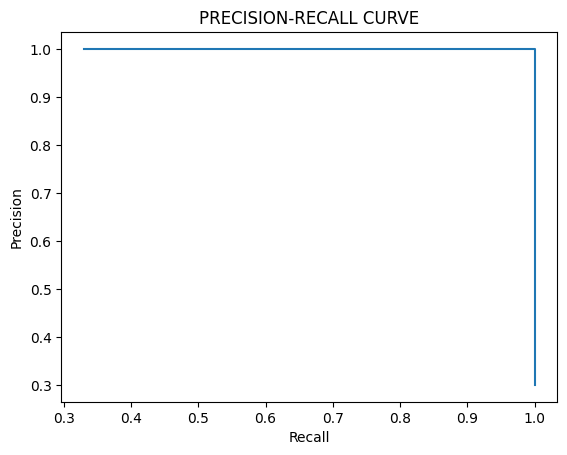

In [17]:
relevant = 0
retrieved = 0
total_relevant = len(relevant_docs)
map_val = 0
recall = list()
precision = list()
print("\nEvaluation Metrics: (Precision, Recall) :\n")
for key in topk2_sorted:
    retrieved += 1
    if str(key) in relevant_docs:
        relevant += 1
        map_val += round((relevant/retrieved), 2)
    recall.append(round((relevant/total_relevant),2))
    precision.append(round((relevant/retrieved), 2))
    print("Precision : ", round((relevant/retrieved), 2), " Recall : ", round((relevant/total_relevant),2), "\n")

print("\nMean Average Precision(MAP) for the above query is: ", map_val/relevant)

# use matplotlib to plot P-R curve
plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("PRECISION-RECALL CURVE")
plt.show()

Store relevance feedback information in "relevance_feedback.json" 

In [18]:
import json
item = dict()

for eachs in final_symp:
    item[eachs] = relevant_docs
print(item)
with open("relevance_feedback.json", "w", encoding='utf-8') as file:
    json.dump(item, file, indent=4)
    file.close()

{'coughing': ['35', '144', '119'], 'fever': ['35', '144', '119'], 'headache': ['35', '144', '119'], 'vomiting': ['35', '144', '119']}


Extracting relevant queries based on the rlevance feedback

In [19]:
import ast
f = open("relevance_feedback.json", 'r')
relevance_feedback = json.load(f)
f.close()
relevant_queries = list(relevance_feedback.keys())
print(relevant_queries)

['coughing', 'fever', 'headache', 'vomiting']


Finalised top k relevant diseases based on relevance feedback and cosine similarity

In [20]:
ranking = dict()
original = cosine_similarity(k,final_symp)
relevance_score = 0.1
for query in final_symp:
    for doc in topk2_sorted.keys():
        if(query in relevant_queries and str(doc) in relevance_feedback[query]):
            original[int(doc)] = original[int(doc)] + relevance_score
    final_similarity =  dict(sorted(original.items(), key = lambda x : x[1], reverse = True))
    

print(f"Top {k} disease after Relevance Feedback :\n ")
j = 0
topk2_index_mapping = {}
for key in final_similarity:
  print(f"{j}. Disease [{key}] : {diseases[key]} \t Score : {round(final_similarity[key], 2)}")
  topk2_index_mapping[j] = diseases[key]
  j += 1

Top 10 disease after Relevance Feedback :
 
0. Disease [35] : Brucellosis 	 Score : 1.18
1. Disease [144] : Malaria 	 Score : 1.02
2. Disease [119] : Influenza 	 Score : 0.89
3. Disease [36] : Bubonic plague 	 Score : 0.42
4. Disease [207] : Rocky Mountain spotted fever 	 Score : 0.41
5. Disease [21] : Asthma 	 Score : 0.37
6. Disease [125] : Japanese Encephalitis 	 Score : 0.35
7. Disease [95] : Gastroenteritis 	 Score : 0.32
8. Disease [136] : Leptospirosis 	 Score : 0.31
9. Disease [206] : Rift Valley fever 	 Score : 0.31
